# DL Project 3 - Jailbreaking Models

### Dependencies
Import necessary libraries.

In [1]:
import os
import shutil
import json
import math

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToPILImage
from torch.utils.data import DataLoader, Dataset

import numpy as np
import pandas as pd

from tqdm.auto import tqdm
from PIL import Image
import matplotlib.pyplot as plt

from typing import Callable, Dict, List, Optional, Sequence, Tuple

# 2) or filter it once at the top of your notebook / script
import warnings
warnings.filterwarnings("ignore",
    message="You are using `torch.load` with `weights_only=False`", category=FutureWarning)



### Configuration & Dataset Setup
Define paths, hyperparameters, device, and transformations. Generate the necessary ImageNet class index JSON if it doesn't exist.


In [2]:
# --- General Configuration ---
# Path to your TestDataSet directory
DATASET_PATH = "/kaggle/input/testdatasetproject3/TestDataSet" # Adjust if needed
# Path to the labels_list.json file you provided
LABELS_JSON_PATH = os.path.join(DATASET_PATH, "labels_list.json") # Assumes it's inside TestDataSet
# Path where the generated imagenet_class_index.json will be saved
# Save in the current directory where the notebook is run
GENERATED_JSON_PATH = "./imagenet_class_index.json"

BATCH_SIZE = 32 # You can adjust this based on your hardware

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define preprocessing transforms
mean_norms = np.array([0.485, 0.456, 0.406])
std_norms = np.array([0.229, 0.224, 0.225])

plain_transforms = transforms.Compose([
    transforms.ToTensor(), # Converts PIL Image to Tensor and scales to [0, 1]
    transforms.Normalize(mean=mean_norms, std=std_norms) # Normalizes tensor
])

# --- Attack Configurations ---
# Task 2: FGSM L-infinity attack
ADVERSARIAL_SAVE_PATH_TASK1 = "./AdversarialTestSet1_FGSM" # Directory to save adversarial images

# Task 3: Improved L-infinity attack
ADVERSARIAL_SAVE_PATH_TASK2 = "./AdversarialTestSet2_ImprovedLinf"

# Task 4: Patch attack
ADVERSARIAL_SAVE_PATH_TASK3 = "./AdversarialTestSet3_Patch"

Using device: cuda


In [3]:

if not os.path.exists(GENERATED_JSON_PATH):
    print(f"Generating ImageNet class index JSON at {GENERATED_JSON_PATH}...")
    try:
        # 1. Get sorted list of folder names (ILSVRC IDs) from the dataset directory
        entries = os.listdir(DATASET_PATH)
        folder_names = sorted([name for name in entries if os.path.isdir(os.path.join(DATASET_PATH, name))])

        if not folder_names:
            print(f"Error: No subdirectories found in {DATASET_PATH}. Cannot generate JSON.")
        else:
            # 2. Read and parse the provided labels_list.json file
            with open(LABELS_JSON_PATH, 'r') as f:
                labels_list = json.load(f)

            if not isinstance(labels_list, list):
                print(f"Error: The file {LABELS_JSON_PATH} is not a list as expected. Cannot generate JSON.")
            else:
                parsed_labels = []
                for entry in labels_list:
                    if not isinstance(entry, str):
                        print(f"Warning: Unexpected entry format in JSON: {entry}. Skipping.")
                        continue
                    parts = entry.split(': ', 1)
                    if len(parts) == 2:
                        index_str, class_name = parts
                        if not index_str.isdigit():
                             print(f"Warning: Index '{index_str}' is not purely numeric in entry '{entry}'. Using as is.")
                        parsed_labels.append((index_str, class_name))
                    else:
                        print(f"Warning: Could not parse entry '{entry}'. Expected format 'Index: Class Name'. Skipping.")

                if len(folder_names) != len(parsed_labels):
                    print(f"Error: Mismatch between number of folders ({len(folder_names)}) and parsed class entries ({len(parsed_labels)}). Cannot reliably generate the mapping.")
                else:
                    # 3. Create the standard ImageNet class index dictionary
                    imagenet_class_index = {}
                    for i in range(len(folder_names)):
                        index_str, class_name = parsed_labels[i]
                        ilsrvc_id = folder_names[i]
                        imagenet_class_index[index_str] = [ilsrvc_id, class_name]

                    # 4. Save the generated dictionary
                    with open(GENERATED_JSON_PATH, 'w') as f:
                        json.dump(imagenet_class_index, f, indent=2, sort_keys=True)
                    print(f"Successfully saved ImageNet class index JSON to {GENERATED_JSON_PATH}")

    except FileNotFoundError:
        print(f"Error: Could not find dataset path ({DATASET_PATH}) or labels JSON path ({LABELS_JSON_PATH}).")
    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON from {LABELS_JSON_PATH}. Check file validity.")
    except Exception as e:
        print(f"An unexpected error occurred during JSON generation: {e}")
else:
    print(f"ImageNet class index JSON already exists at {GENERATED_JSON_PATH}. Skipping generation.")


# Update JSON_PATH to the generated one
JSON_PATH = GENERATED_JSON_PATH

Generating ImageNet class index JSON at ./imagenet_class_index.json...
Successfully saved ImageNet class index JSON to ./imagenet_class_index.json


## Load Data and Pretrained ResNet-34 Model

In [4]:
def load_model_and_data(dataset_path=DATASET_PATH, json_path=JSON_PATH, batch_size=BATCH_SIZE, device=device, transforms=plain_transforms):
    """Loads model, dataset, dataloader, and class mapping."""
    print("Loading pre-trained ResNet-34 model...")
    try:
        model = torchvision.models.resnet34(weights='IMAGENET1K_V1').to(device)
        model.eval() # Set model to evaluation mode
        # print("Model loaded successfully.") # Less verbose print
    except Exception as e:
        print(f"Error loading model: {e}")
        print("Please ensure you have an internet connection to download weights.")
        return None, None, None, None, None

    # print("Transforms defined.") # Removed verbose print

    # print(f"Loading dataset from {dataset_path}...") # Less verbose print
    if not os.path.exists(dataset_path):
        print(f"Error: Dataset path not found at {dataset_path}")
        return None, None, None, None, None
    try:
        dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=transforms) # Use passed transforms
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
        print(f"Dataset loaded successfully with {len(dataset)} images in {len(dataset.classes)} classes.")
    except Exception as e:
         print(f"Error loading dataset: {e}")
         print("Please check the dataset path and format.")
         return None, None, None, None, None

    # print(f"Loading ImageNet class index mapping from {json_path}...") # Less verbose print
    if not os.path.exists(json_path):
         print(f"Error: JSON path not found at {json_path}")
         print("Please ensure the correct imagenet_class_index.json file is in the correct location.")
         return None, None, None, None, None
    try:
        with open(json_path) as f:
            class_idx = json.load(f)

        if not isinstance(class_idx, dict):
             print("Error processing JSON file: JSON is not in the expected dictionary format.")
             print("Please ensure you are using the standard imagenet_class_index.json file.")
             return None, None, None, None, None

        # Create a mapping from ILSVRC_ID (folder name) to ImageNet integer index (0-999)
        imagenet_id_to_index = {v[0]: int(k) for k, v in class_idx.items()}

        # Create the mapping from ImageFolder index (0-99) to the correct ImageNet index (0-999)
        imgfolder_idx_to_imagenet_idx = []
        for folder_name in dataset.classes:
            if folder_name in imagenet_id_to_index:
                imgfolder_idx_to_imagenet_idx.append(imagenet_id_to_index[folder_name])
            else:
                # This indicates the generated JSON might be incomplete for this dataset
                print(f"Error: Folder name '{folder_name}' from dataset not found in the ImageNet ID to index mapping. Cannot proceed.")
                return None, None, None, None, None


        imgfolder_idx_to_imagenet_idx_tensor = torch.tensor(imgfolder_idx_to_imagenet_idx).to(device)

        # Also create a map from the full ImageNet index back to class name for visualization
        imagenet_index_to_name = {int(k): v[1] for k, v in class_idx.items()}

        # print("ImageNet class index mapping loaded and processed.") # Less verbose print
    except Exception as e:
        print(f"Error loading or processing JSON file: {e}")
        print("Please check the JSON file format and path.")
        return None, None, None, None, None

    return model, dataset, dataloader, imgfolder_idx_to_imagenet_idx_tensor, imagenet_index_to_name


## Evaluate Model Function

In [5]:
def evaluate_model(model, dataloader, true_label_mapping_tensor, imagenet_index_to_name=None):
    """Evaluates model performance on a dataloader and reports Top-1 and Top-5 accuracy."""
    correct_top1 = 0
    correct_top5 = 0
    total_samples = 0

    model.eval() # Ensure model is in eval mode
    with torch.no_grad():
        # Use dataloader's disable=True argument for tqdm if you don't want a progress bar
        for images, labels_imgfolder_idx in tqdm(dataloader, desc="Evaluating", leave=False): # leave=False cleans up the bar after completion
            images = images.to(device)
            labels_imgfolder_idx = labels_imgfolder_idx.to(device)

            # Map ImageFolder index to ImageNet index
            true_imagenet_labels = true_label_mapping_tensor[labels_imgfolder_idx]

            outputs = model(images)

            _, predicted_top1 = outputs.topk(1, dim=1, largest=True, sorted=True)
            _, predicted_top5 = outputs.topk(5, dim=1, largest=True, sorted=True)

            total_samples += labels_imgfolder_idx.size(0)

            correct_top1 += (predicted_top1 == true_imagenet_labels.unsqueeze(1)).sum().item()
            correct_top5 += (true_imagenet_labels.unsqueeze(1) == predicted_top5).any(dim=1).sum().item()

    top1_accuracy = (correct_top1 / total_samples) * 100
    top5_accuracy = (correct_top5 / total_samples) * 100

    return top1_accuracy, top5_accuracy

## Adversarial Attacks on Dataset

In [6]:

def tensor_to_pil(image_tensor, mean, std):
    """Converts a normalized tensor image (C, H, W) to a PIL Image (uint8, HxWx3)."""
    
    def unnormalize(image_tensor, mean, std):
        """Unnormalizes a tensor image."""
        mean = torch.tensor(mean).to(image_tensor.device).view(-1, 1, 1)
        std = torch.tensor(std).to(image_tensor.device).view(-1, 1, 1)
        unnormalized_image = image_tensor * std + mean
        return unnormalized_image
    
    unnormalized_image = unnormalize(image_tensor, mean, std)
    unnormalized_image = torch.clamp(unnormalized_image, 0, 1)
    img_np = (unnormalized_image * 255).byte().permute(1, 2, 0).cpu().numpy()
    img_pil = Image.fromarray(img_np, 'RGB')
    return img_pil


def generate_attack_adversarial(
    original_dataset: Dataset,
    model: torch.nn.Module,
    device: torch.device,
    imgfolder2imagenet: torch.Tensor,
    mean_norms, std_norms,
    attack_fn: Callable,
    save_root: str,
    dataset_root: str = DATASET_PATH,
    attack_kwargs: Dict = {}
):

    if os.path.exists(save_root):
        shutil.rmtree(save_root)
    os.makedirs(save_root, exist_ok=True)
    for cls in original_dataset.classes:
        os.makedirs(os.path.join(save_root, cls), exist_ok=True)

    samples = original_dataset.samples
    model.eval()

    for i in tqdm(range(len(original_dataset)), desc=f"{attack_fn.__name__} adv"):
        img_path, _ = samples[i]
        img_cpu, cls_idx = original_dataset[i]

        img     = img_cpu.unsqueeze(0).to(device)
        target  = imgfolder2imagenet[cls_idx].unsqueeze(0).to(device)
        adv     = attack_fn(model, img, target, **attack_kwargs).squeeze(0).cpu()

        rel     = os.path.relpath(img_path, dataset_root)      # keep class-subdir layout
        base    = os.path.join(save_root, os.path.splitext(rel)[0])  # without ext

        # ---- loss-less PT ----
        torch.save(adv.cpu(), base + ".pt")   # e.g. .../n02009912/123.pt

    print(f"Saved adversarial tensors to {save_root}")

def visualize_adversarial_examples(
    original_dataset: ImageFolder,
    model: torch.nn.Module,
    device: torch.device,
    imgfolder2imagenet: torch.Tensor,
    imagenet_idx_to_name: dict,
    mean_norms, std_norms,
    attack_fn: Callable,
    attack_kwargs: Dict,
    tensor_to_pil_fn: Callable,
    num_visualize: int = 2,
    tile_size: float = 5,
    k_predictions: int = 5
):
    """
    Visualizes original, adversarial, noise (grayscale diff), and predictions for random examples.
    """
    model.eval()
    N = len(original_dataset)
    num_visualize = min(num_visualize, N)
    if num_visualize == 0:
        print("No examples to visualize.")
        return

    idxs = np.random.choice(N, num_visualize, replace=False)
    fig, axes = plt.subplots(
        num_visualize, 4,
        figsize=(4 * tile_size, num_visualize * tile_size),
        squeeze=False
    )

    attack_name = getattr(attack_fn, '__name__', 'CustomAttack')
    eps = attack_kwargs.get('epsilon', 'N/A')
    fig.suptitle(f"Adversarial Attack Visualization ({attack_name}, ε={eps})", fontsize=14, y=1.02)

    get_name = lambda idx: imagenet_idx_to_name.get(idx, f"Index {idx} (NA)")

    for row, i in enumerate(idxs):
        img_cpu, cls_idx = original_dataset[i]
        img_orig = img_cpu.unsqueeze(0).to(device)
        true_imagenet_id = imgfolder2imagenet[cls_idx].item()

        try:
            adv_batch = attack_fn(model, img_orig.clone(), imgfolder2imagenet[cls_idx].unsqueeze(0).to(device), **attack_kwargs)
        except Exception as e:
            for col in range(4): axes[row, col].axis('off')
            continue
        adv_cpu = adv_batch.squeeze(0).cpu()

        # Difference grayscale
        diff_cpu = adv_cpu - img_cpu.cpu()
        abs_max_diff = diff_cpu.abs().max().item()
        diff_gray = diff_cpu.mean(dim=0).numpy()

        # Predictions
        with torch.no_grad():
            out_orig = model(img_orig)
            out_adv = model(adv_batch.to(device))
            _, pred_o = out_orig.topk(1, 1)
            probs_adv = torch.softmax(out_adv, 1)
            confs, idxs_adv = probs_adv.topk(k_predictions, 1)
        pred_adv_ids = idxs_adv.squeeze().cpu().numpy()
        confidences = confs.squeeze().cpu().numpy()
        names = [get_name(idx) for idx in pred_adv_ids]
        order = np.argsort(confidences)

        # Plot original
        axes[row,0].imshow(tensor_to_pil_fn(img_cpu, mean_norms, std_norms))
        axes[row,0].set_title(
            f"Orig\nTrue: {get_name(true_imagenet_id)}\nPred: {get_name(pred_o.item())}", fontsize=8)
        axes[row,0].axis('off')

        # Plot adversarial
        l_inf = abs_max_diff
        axes[row,1].imshow(tensor_to_pil_fn(adv_cpu, mean_norms, std_norms))
        axes[row,1].set_title(f"Adv\nL∞={l_inf:.4f}", fontsize=8)
        axes[row,1].axis('off')

        # Plot noise (grayscale)
        axes[row,2].imshow(diff_gray, vmin=-abs_max_diff, vmax=abs_max_diff, cmap='RdBu')
        axes[row,2].set_title(f"Noise\n±{abs_max_diff:.4f}", fontsize=8)
        axes[row,2].axis('off')

        # Plot adv predictions
        sorted_names = [names[j] for j in order]
        sorted_confs = confidences[order]
        axes[row,3].barh(sorted_names, sorted_confs)
        axes[row,3].set_xlim(0,1.05)
        axes[row,3].invert_yaxis()
        axes[row,3].tick_params(labelsize=7)
        axes[row,3].set_title("Adv Predictions", fontsize=8)

    plt.tight_layout(pad=1.5)
    plt.show()

    
def load_adversarial_dataloader_pt(
    root: str,
    batch_size: int,
    mapping_tensor: torch.Tensor,
    orig_classes: list
) -> Tuple[Optional[DataLoader], Optional[torch.Tensor]]:
    """
    Load a directory that contains ONLY the .pt files produced by
    generate_attack_adversarial().  Each .pt stores a normalised
    adversarial image tensor (C,H,W, float32).

    Returns (dataloader, mapping_tensor) or (None, None) on error.
    """

    # accept files ending in ".pt" only
    def is_pt(fname: str) -> bool:
        return fname.endswith(".pt")

    try:
        ds = ImageFolder(
            root=root,
            loader=torch.load,
            is_valid_file=is_pt,    # ignore .png or anything else
            transform=lambda x: x,
            # identity: tensor already normalised
        )

        # sanity-check class order matches the original dataset
        if ds.classes != orig_classes:
            print("Error: Class order mismatch between original and adversarial sets.")
            return None, None

        dl = DataLoader(
            ds,
            batch_size=batch_size,
            shuffle=False,
            num_workers=0,
            pin_memory=True
        )
        return dl, mapping_tensor

    except Exception as e:
        print(f"Error loading adversarial dataloader from {root}: {e}")
        return None, None


def evaluate_adversarial_dataset(
    model: torch.nn.Module,
    dataloader: DataLoader,
    mapping_tensor: torch.Tensor,
    imagenet_idx_to_name: dict,
    epsilon: float,
    baseline_top1: Optional[float] = None,
    baseline_top5: Optional[float] = None
) -> Tuple[float, float]:
    """
    Run evaluate_model on adversarial dataloader, print Top-1/5 accuracies and relative drops.
    Returns (top1_acc, top5_acc).
    """
    top1, top5 = evaluate_model(model, dataloader, mapping_tensor, imagenet_idx_to_name)
    
    return top1, top5


## Task 1: Basics
- Loads and preprocessed images from dataset
- Loads pretrained ResNet-34
- Evaluates model on standard data to establish a baseline
- Creates Top1 and Top5 Accuracy baselines

In [7]:
model, original_dataset, dataloader, imgfolder_idx_to_imagenet_idx_tensor, imagenet_index_to_name = load_model_and_data()

Loading pre-trained ResNet-34 model...


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 187MB/s]


Dataset loaded successfully with 500 images in 100 classes.


In [8]:
baseline_top1_accuracy, baseline_top5_accuracy = evaluate_model(
    model, dataloader, imgfolder_idx_to_imagenet_idx_tensor, imagenet_index_to_name
)

print("\n--- Task 1 Results (Baseline) ---")
print(f"Top-1 Accuracy: {baseline_top1_accuracy:.2f}%")
print(f"Top-5 Accuracy: {baseline_top5_accuracy:.2f}%")
print("---------------------------------")

# Store baseline results for relative drop calculation
global_baseline_top1 = baseline_top1_accuracy
global_baseline_top5 = baseline_top5_accuracy

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]


--- Task 1 Results (Baseline) ---
Top-1 Accuracy: 76.00%
Top-5 Accuracy: 94.20%
---------------------------------


## Task 2: Pixel-wise Attacks (FGSM)
Generate adversarial images using the FGSM attack, save them, visualize examples, and evaluate the model on the adversarial dataset. FGSM_EPSILON = 0.02


In [9]:
def fgsm_attack(model, image, label, epsilon):
    """
    Performs the FGSM attack.
    Args:
        model: The PyTorch model.
        image: Input image tensor (normalized, requires_grad=True). Shape (B, C, H, W)
        label: True label tensor. Shape (B,) or (B, 1)
        epsilon: The maximum perturbation amount (L-infinity norm).
    Returns:
        The adversarial image tensor (normalized). Shape (B, C, H, W)
    """
    # Ensure image requires grad
    image.requires_grad = True

    # Forward pass the image through the model
    output = model(image)

    # Calculate the loss
    # Use CrossEntropyLoss. The model outputs logits, which is what CE Loss expects.
    # If label is (B, 1), reshape to (B,)
    if label.dim() > 1:
        label = label.squeeze(1)
    criterion = torch.nn.CrossEntropyLoss()
    loss = criterion(output, label)

    # Zero all existing gradients
    model.zero_grad()

    # Calculate gradient of loss with respect to input image
    loss.backward()

    # Collect the gradient with respect to the input image
    data_grad = image.grad.data

    # Get the sign of the gradients
    sign_data_grad = data_grad.sign()

    # Create the perturbed image
    perturbed_image = image + epsilon * sign_data_grad

    # Clamp the resulting image to ensure the L-infinity constraint is met relative to the original image
    # This ensures each pixel perturbation is within [-epsilon, epsilon]
    perturbed_image = torch.max(torch.min(perturbed_image, image + epsilon), image - epsilon)

    # Detach the perturbed image to remove it from the computation graph
    return perturbed_image.detach()



In [10]:
fgsm_params = {"epsilon": 0.02}

# 1) Generate & save FGSM adversarial set
generate_attack_adversarial(
    original_dataset=original_dataset,
    model=model,
    device=device,
    imgfolder2imagenet=imgfolder_idx_to_imagenet_idx_tensor,
    mean_norms=mean_norms,
    std_norms=std_norms,
    attack_fn=fgsm_attack,
    save_root=ADVERSARIAL_SAVE_PATH_TASK1,
    attack_kwargs=fgsm_params
)

fgsm_attack adv:   0%|          | 0/500 [00:00<?, ?it/s]

Saved adversarial tensors to ./AdversarialTestSet1_FGSM


In [11]:
dl_adv, map_adv = load_adversarial_dataloader_pt(
    root=ADVERSARIAL_SAVE_PATH_TASK1,
    batch_size=BATCH_SIZE,
    mapping_tensor=imgfolder_idx_to_imagenet_idx_tensor,
    orig_classes=original_dataset.classes
)


fgsm_top1, fgsm_top5 = evaluate_adversarial_dataset(
    model, dl_adv, map_adv, imagenet_index_to_name,
    epsilon=fgsm_params["epsilon"],
    baseline_top1=global_baseline_top1,
    baseline_top5=global_baseline_top5
)

print(f"\n--- FGSM ε={fgsm_params['epsilon']} Results ---")
print(f"Top-1 Accuracy: {fgsm_top1:.2f}%")
print(f"Top-5 Accuracy: {fgsm_top5:.2f}%")
print("--------------------------------")
if baseline_top1_accuracy is not None:
    drop1 = (baseline_top1_accuracy - fgsm_top1) / baseline_top1_accuracy * 100
    print(f"Top-1 Relative Drop: {drop1:.2f}%")
if baseline_top5_accuracy is not None:
    drop5 = (baseline_top5_accuracy - fgsm_top5) / baseline_top5_accuracy * 100
    print(f"Top-5 Relative Drop: {drop5:.2f}%")
print("-------------------------------")

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]


--- FGSM ε=0.02 Results ---
Top-1 Accuracy: 6.00%
Top-5 Accuracy: 35.40%
--------------------------------
Top-1 Relative Drop: 92.11%
Top-5 Relative Drop: 62.42%
-------------------------------


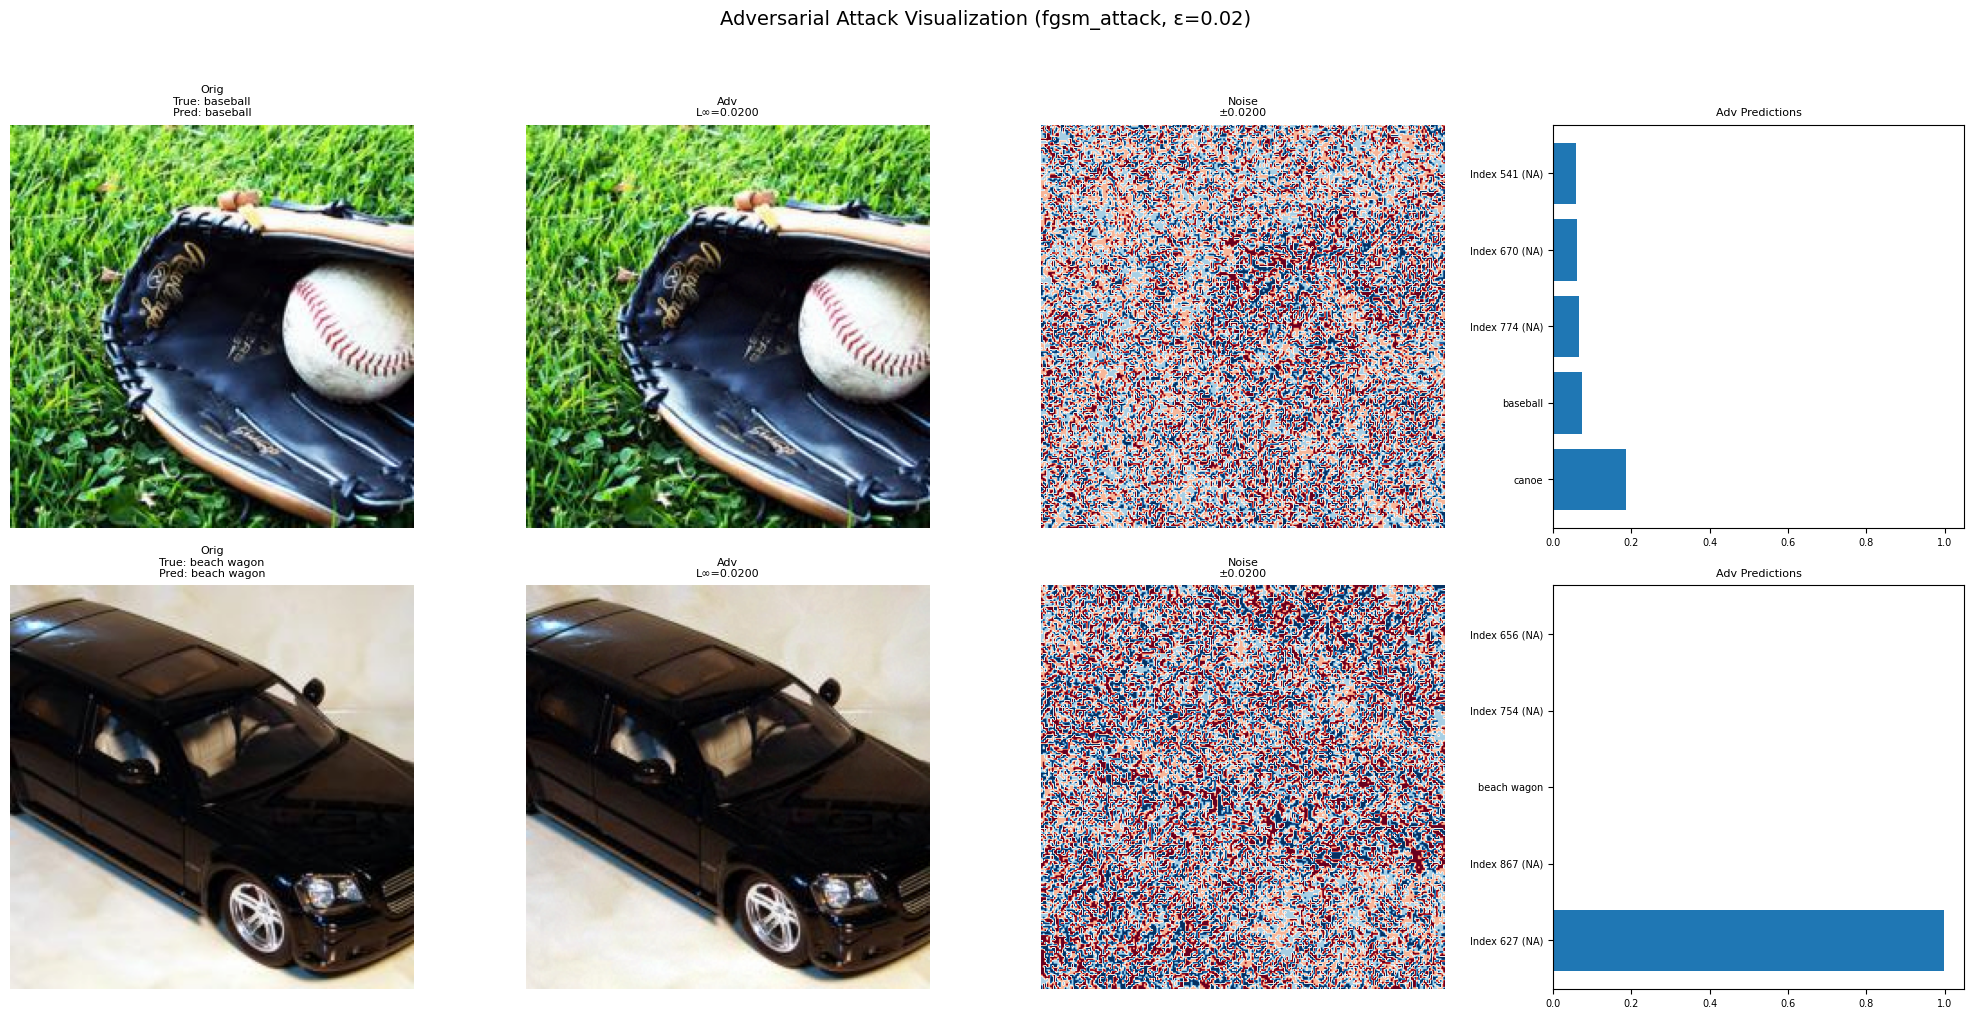

In [12]:
visualize_adversarial_examples(
    original_dataset=original_dataset,
    model=model,
    device=device,
    imgfolder2imagenet=imgfolder_idx_to_imagenet_idx_tensor,
    imagenet_idx_to_name=imagenet_index_to_name,
    mean_norms=mean_norms,
    std_norms=std_norms,
    attack_fn=fgsm_attack,
    attack_kwargs=fgsm_params,
    tensor_to_pil_fn=tensor_to_pil,
)


## Task 3: Improved L-Inf Attacks


In [13]:
def pgd_linf_attack(
    model,
    images, # Original image tensor (normalized). Shape (B, C, H, W)
    labels, # True label tensor. Shape (B,) - Should be ImageNet indices (0-999).
    epsilon, # L-inf budget for the *entire image*.
    num_steps, # Number of PGD steps.
    step_size, # Step size for PGD.
    random_init=True, # Random initialization within the epsilon ball.
    # targeted=False, # Optional: for targeted attack
    # target_class=None # Optional: target class index for targeted attack
):
    """
    Performs an untargeted PGD L-infinity attack on the entire image.
    Args:
        model: The PyTorch model.
        images: Original input image tensor (normalized). Shape (B, C, H, W)
        labels: True label tensor. Shape (B,)
        epsilon: The maximum perturbation amount (L-infinity norm) across the entire image.
        num_steps: Number of PGD iterations.
        step_size: Step size for each iteration's gradient update.
        random_init: If True, initialize with random noise within [-epsilon, epsilon].
    Returns:
        The adversarial image tensor (normalized). Shape (B, C, H, W)
    """
    # Ensure labels have correct shape (B,)
    if labels.dim() > 1:
        labels = labels.squeeze(1)

    # Store the original image for projection
    original_images = images.detach().clone() # Shape (B, C, H, W)

    # Initialize adversarial image
    x_adv = original_images.clone()

    if random_init:
        # Add random noise uniformly sampled from [-epsilon, epsilon]
        random_noise = torch.rand_like(original_images, device=images.device) * 2 * epsilon - epsilon
        x_adv = original_images + random_noise
        # Project back to the epsilon ball around the original image
        x_adv = torch.max(torch.min(x_adv, original_images + epsilon), original_images - epsilon)
        # x_adv = torch.clamp(x_adv, 0, 1) # Optional: Clamp to [0,1] range after unnormalization (not standard for L-inf on normalized data)


    # Loss function (Untargeted: maximize loss w.r.t true label)
    criterion = torch.nn.CrossEntropyLoss()

    # PGD Iterations
    for step in range(num_steps):
        # Make x_adv a leaf variable that requires gradients for the current step
        x_adv.requires_grad_(True)

        # Forward pass
        output = model(x_adv)

        # Calculate loss (untargeted: maximize loss w.r.t true label)
        # Pytorch's loss.backward() computes gradients that *decrease* the loss.
        # For untargeted attack (maximizing loss for true label), we use gradient ASCENT.
        # So, we calculate loss and use the gradients to move in the *positive* direction.
        loss = criterion(output, labels)

        # Zero gradients
        model.zero_grad()

        # Backward pass to get gradients w.r.t. x_adv
        loss.backward()

        # Get gradient w.r.t. x_adv and take the sign (for FGSM)
        # For PGD, we use the actual gradient direction, not just the sign
        # Get gradient w.r.t. x_adv
        if x_adv.grad is None:
             print(f"Warning: Gradient is None at step {step}. Stopping PGD attack for this batch.")
             break # Exit the step loop

        data_grad = x_adv.grad.data

        # Detach x_adv from the graph before updating it
        x_adv_detached = x_adv.detach()

        # Apply gradient update (gradient ascent)
        # Use step_size * data_grad / data_grad.abs().mean() if you want steps normalized by gradient magnitude,
        # but typically just step_size * data_grad.sign() for L-inf or step_size * data_grad for L2/L1.
        # For L-inf PGD, the step is usually applied using the *sign* of the gradient, like FGSM, but iteratively.
        # Let's use the sign based update for L-inf PGD.
        x_adv_updated = x_adv_detached + step_size * data_grad.sign()


        # Project back to the L-infinity ball around the original image
        # This ensures the perturbation never exceeds epsilon for *any* pixel
        x_adv_projected = torch.max(torch.min(x_adv_updated, original_images + epsilon), original_images - epsilon)

        # Optional: Clamp to the normalized image range if needed, but projection relative to original is primary.
        # x_adv_projected = torch.clamp(x_adv_projected, images.min(), images.max()) # This is not the correct way to clamp after normalization


        # Update x_adv for the next iteration
        x_adv = x_adv_projected.detach() # Detach for the next iteration

    # Return the final adversarial image
    return x_adv.detach() # Ensure the final result is detached

In [14]:
pgd_linf_params = {
  "epsilon":     0.02,   # L∞ bound
  "num_steps":   10,     # number of steps
  "step_size":   0.002,  # epsilon / 10 = 0.02 / 10 = 0.002 
  "random_init": True    # Keep random initialization
}

# 1) Generate & save FGSM adversarial set
generate_attack_adversarial(
    original_dataset=original_dataset,
    model=model,
    device=device,
    imgfolder2imagenet=imgfolder_idx_to_imagenet_idx_tensor,
    mean_norms=mean_norms,
    std_norms=std_norms,
    attack_fn=pgd_linf_attack,
    save_root=ADVERSARIAL_SAVE_PATH_TASK2,
    attack_kwargs=pgd_linf_params
)

pgd_linf_attack adv:   0%|          | 0/500 [00:00<?, ?it/s]

Saved adversarial tensors to ./AdversarialTestSet2_ImprovedLinf


In [15]:
dl_adv, map_adv = load_adversarial_dataloader_pt(
    root=ADVERSARIAL_SAVE_PATH_TASK2,
    batch_size=BATCH_SIZE,
    mapping_tensor=imgfolder_idx_to_imagenet_idx_tensor,
    orig_classes=original_dataset.classes
)


pgd_top1, pgd_top5 = evaluate_adversarial_dataset(
    model, dl_adv, map_adv, imagenet_index_to_name,
    epsilon=pgd_linf_params["epsilon"],
    baseline_top1=global_baseline_top1,
    baseline_top5=global_baseline_top5
)

print(f"\n--- PGD ε={pgd_linf_params['epsilon']} Results ---")
print(f"Top-1 Accuracy: {pgd_top1:.2f}%")
print(f"Top-5 Accuracy: {pgd_top5:.2f}%")
print("--------------------------------")
if baseline_top1_accuracy is not None:
    drop1 = (baseline_top1_accuracy - pgd_top1) / baseline_top1_accuracy * 100
    print(f"Top-1 Relative Drop: {drop1:.2f}%")
if baseline_top5_accuracy is not None:
    drop5 = (baseline_top5_accuracy - pgd_top5) / baseline_top5_accuracy * 100
    print(f"Top-5 Relative Drop: {drop5:.2f}%")
print("-------------------------------")

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]


--- PGD ε=0.02 Results ---
Top-1 Accuracy: 0.20%
Top-5 Accuracy: 20.00%
--------------------------------
Top-1 Relative Drop: 99.74%
Top-5 Relative Drop: 78.77%
-------------------------------


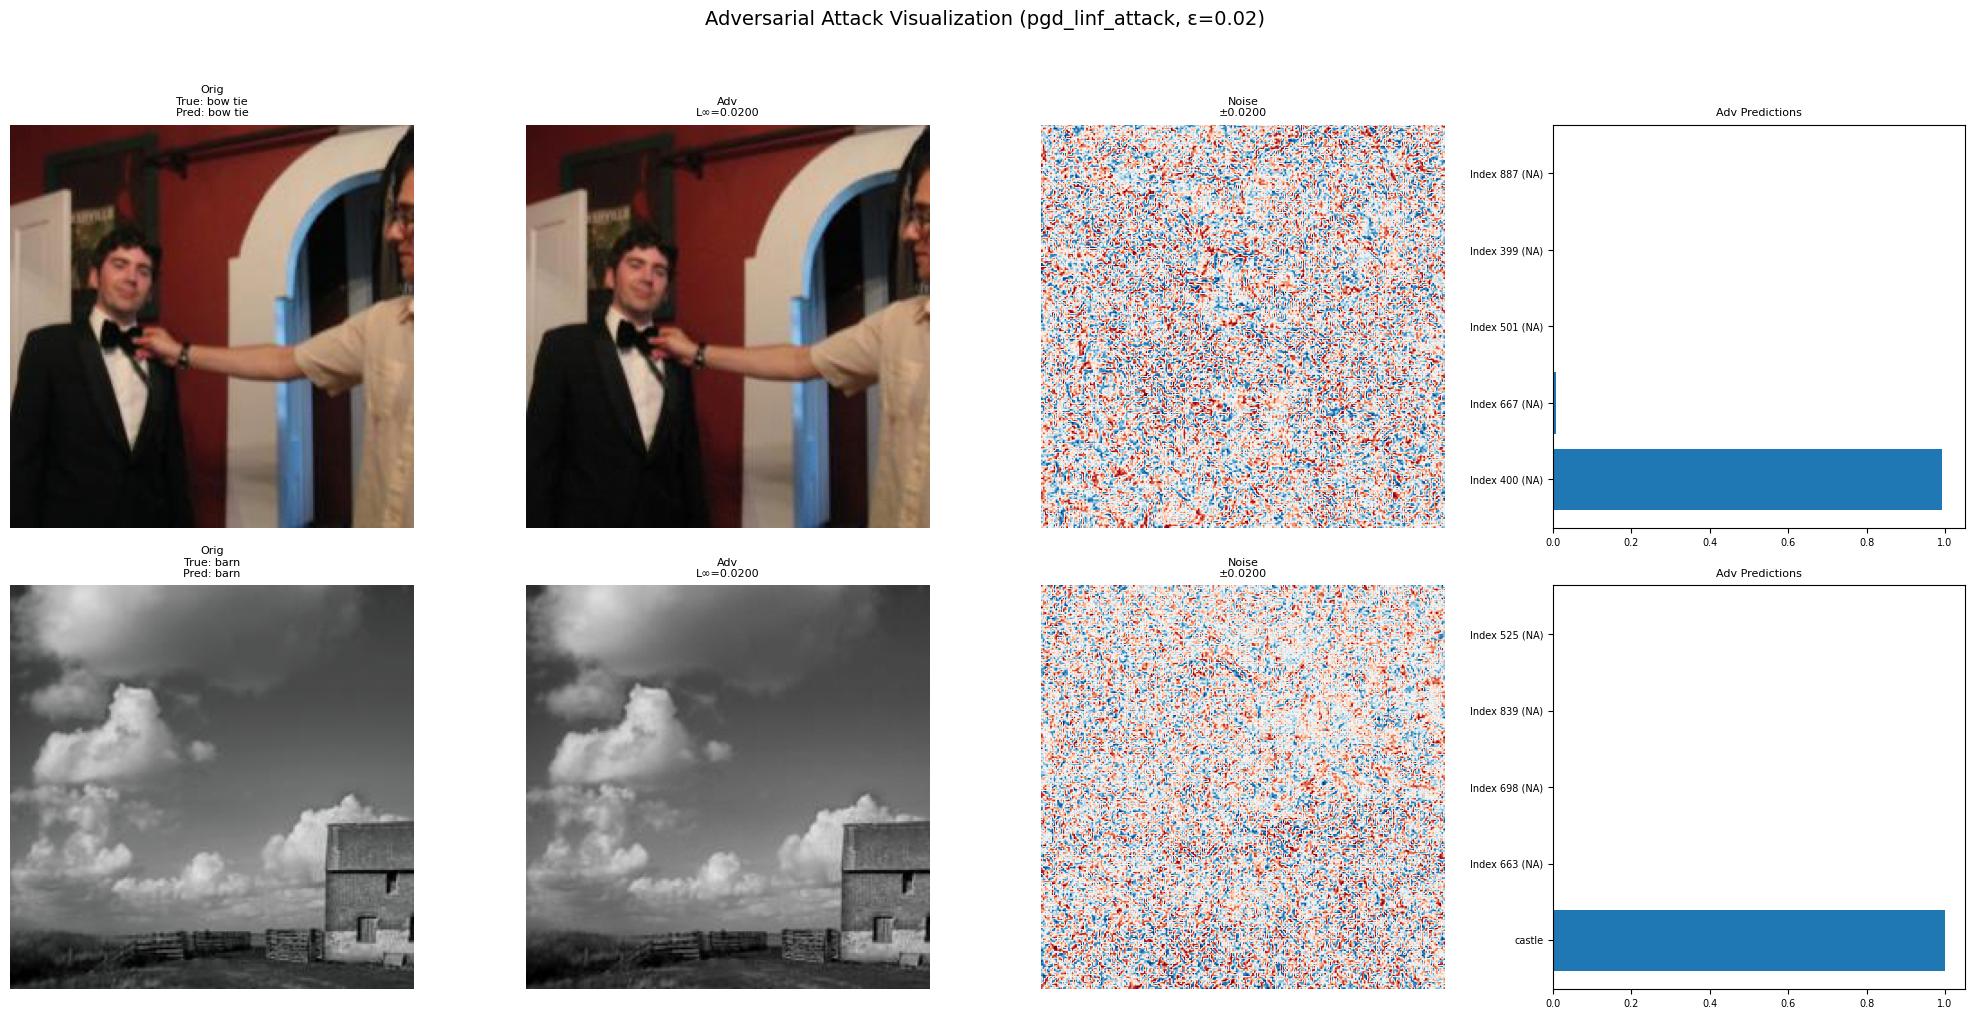

In [16]:
visualize_adversarial_examples(
    original_dataset=original_dataset,
    model=model,
    device=device,
    imgfolder2imagenet=imgfolder_idx_to_imagenet_idx_tensor,
    imagenet_idx_to_name=imagenet_index_to_name,
    mean_norms=mean_norms,
    std_norms=std_norms,
    attack_fn=pgd_linf_attack,
    attack_kwargs=pgd_linf_params,
    tensor_to_pil_fn=tensor_to_pil,
)

## Task 4: Patch Attacks



In [17]:
def patch_attack_flex(
    model, images, labels, *,
    patch_size, epsilon,
    num_steps, step_size,
    random_init=True,
    use_saliency=False,       # random vs saliency location
    targeted=False,           # untargeted vs least-likely targeted
    momentum=False, beta=0.9
):
    device = images.device
    B, C, H, W = images.shape

    # -------- choose patch coords -----------------------------------------
    if use_saliency:
        y_coords, x_coords = [], []
        for b in range(B):
            img = images[b:b+1].clone().requires_grad_(True)
            loss = torch.nn.functional.cross_entropy(model(img), labels[b:b+1])
            loss.backward()
            sal = img.grad.abs().sum(1, keepdim=True)
            k = patch_size
            ii = torch.cumsum(torch.cumsum(sal, -1), -2)
            s  = ii[..., k:, k:] - ii[..., :-k, k:] - ii[..., k:, :-k] + ii[..., :-k, :-k]
            idx_max = int(s.argmax().item())          # ← convert to int
            y, x    = divmod(idx_max, W - k + 1)
            y_coords.append(int(y)); x_coords.append(int(x))
        y_coords = torch.tensor(y_coords, device=device)
        x_coords = torch.tensor(x_coords, device=device)
    else:
        y_coords = torch.randint(0, H - patch_size + 1, (B,), device=device)
        x_coords = torch.randint(0, W - patch_size + 1, (B,), device=device)

    # -------- target labels -----------------------------------------------
    if targeted:
        with torch.no_grad():
            target_labels = model(images).argmin(1)
    else:
        target_labels = labels

    # -------- initialise x_adv --------------------------------------------
    x_adv = images.clone()
    if random_init:
        noise = torch.empty_like(x_adv).uniform_(-epsilon, epsilon)
        for b in range(B):
            y, x = y_coords[b], x_coords[b]
            x_adv[b,:,y:y+patch_size,x:x+patch_size] += noise[b,:,y:y+patch_size,x:x+patch_size]
    for b in range(B):
        y, x = y_coords[b], x_coords[b]
        x_adv[b,:,y:y+patch_size,x:x+patch_size].clamp_(
            images[b,:,y:y+patch_size,x:x+patch_size] - epsilon,
            images[b,:,y:y+patch_size,x:x+patch_size] + epsilon
        )

    mom = torch.zeros_like(x_adv)
    crit = torch.nn.CrossEntropyLoss()

    for _ in range(num_steps):
        x_adv.requires_grad_(True)
        loss = crit(model(x_adv), target_labels)
        if targeted:
            loss = -loss
        loss.backward()
        grad = x_adv.grad

        if momentum:
            mom = beta * mom + grad / grad.abs().mean([1,2,3], keepdim=True)
            grad_use = mom
        else:
            grad_use = grad

        with torch.no_grad():
            for b in range(B):
                y, x = y_coords[b], x_coords[b]
                patch = x_adv[b,:,y:y+patch_size,x:x+patch_size]
                patch += step_size * grad_use[b,:,y:y+patch_size,x:x+patch_size].sign()
                patch.clamp_(images[b,:,y:y+patch_size,x:x+patch_size] - epsilon,
                             images[b,:,y:y+patch_size,x:x+patch_size] + epsilon)
        x_adv = x_adv.detach()

    return x_adv

In [18]:
variants = [
    # ───────────────────────────────────────────────────────────────
    # Base Configuration: ε=0.50, 10 steps, Random Init, Random Loc, Untargeted, No Momentum
    # ───────────────────────────────────────────────────────────────
    ("Base Config",
        dict(num_steps=10, step_size=0.50/10,
             random_init=True,
             use_saliency=False,
             targeted=False,
             momentum=False,
             beta=0.9,
             epsilon=0.50)
    ),

    # ───────────────────────────────────────────────────────────────
    # Ablation Variants (changes relative to Base Config)
    # ───────────────────────────────────────────────────────────────
    ("Disable Random Initialization",
        dict(random_init=False)
    ),

    ("Increase Steps to 40",
        dict(num_steps=40, step_size=0.50/40) # Step size adjusted for 40 steps
    ),

    ("Saliency Location",
        dict(use_saliency=True)
    ),

    ("Targeted (Least Likely Class)",
        dict(targeted=True)
    ),

    ("Add Momentum (Beta 0.9)",
        dict(momentum=True, beta=0.90) # Ensure momentum is set to True here
    ),

    ("Add Momentum (Beta 0.99)",
        dict(momentum=True, beta=0.99) # Ensure momentum is set to True here
    ),

    ("Reduce Epsilon to 0.30",
        dict(epsilon=0.30, step_size=0.30/10) # Step size based on 10 steps from base
    ),

    ("Reduce Epsilon to 0.15",
        dict(epsilon=0.15, step_size=0.15/10) # Step size based on 10 steps from base
        # NOTE: Your original code had step_size=0.15/40 here.
        # Adjusted to 0.15/10 based on assumption above.
    ),

    ("Single-Step FGSM Patch",
        dict(num_steps=1, step_size=0.50, # 1 step with full epsilon as step size
             momentum=False,
             targeted=False,
             use_saliency=False, # Random location
             random_init=False,  # No random init
             epsilon=0.50)
    ),
]


In [19]:
records = []

base_params = dict(
    patch_size    = 32,
    epsilon       = 0.50,
    num_steps     = 10,
    step_size     = 0.50/10,
    random_init   = True,
    use_saliency  = False,
    targeted      = False,
    momentum      = False,
    beta          = 0.9            # only used when momentum=True
)

for name, delta in variants:
    params = base_params | delta   # merge dictionaries (Py≥3.9)

    # generate set
    generate_attack_adversarial(
        original_dataset = original_dataset,
        model            = model,
        device           = device,
        imgfolder2imagenet = imgfolder_idx_to_imagenet_idx_tensor,
        mean_norms       = mean_norms,
        std_norms        = std_norms,
        attack_fn        = lambda m,i,l,**kw: patch_attack_flex(m,i,l,**params),
        save_root        = f"{ADVERSARIAL_SAVE_PATH_TASK3}_{name}",
        attack_kwargs    = {}  # we already embed params via the lambda
    )

    # load + evaluate
    dl_adv, map_adv = load_adversarial_dataloader_pt(
        root          = f"{ADVERSARIAL_SAVE_PATH_TASK3}_{name}",
        batch_size    = BATCH_SIZE,
        mapping_tensor= imgfolder_idx_to_imagenet_idx_tensor,
        orig_classes  = original_dataset.classes
    )
    
    top1, top5 = evaluate_adversarial_dataset(
        model, dl_adv, map_adv,
        imagenet_index_to_name,
        epsilon=params["epsilon"],
        baseline_top1=global_baseline_top1,
        baseline_top5=global_baseline_top5
    )
    records.append({"variant": name, "top1": top1, "top5": top5})

<lambda> adv:   0%|          | 0/500 [00:00<?, ?it/s]

Saved adversarial tensors to ./AdversarialTestSet3_Patch_Base Config


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

<lambda> adv:   0%|          | 0/500 [00:00<?, ?it/s]

Saved adversarial tensors to ./AdversarialTestSet3_Patch_Disable Random Initialization


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

<lambda> adv:   0%|          | 0/500 [00:00<?, ?it/s]

Saved adversarial tensors to ./AdversarialTestSet3_Patch_Increase Steps to 40


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

<lambda> adv:   0%|          | 0/500 [00:00<?, ?it/s]

Saved adversarial tensors to ./AdversarialTestSet3_Patch_Saliency Location


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

<lambda> adv:   0%|          | 0/500 [00:00<?, ?it/s]

Saved adversarial tensors to ./AdversarialTestSet3_Patch_Targeted (Least Likely Class)


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

<lambda> adv:   0%|          | 0/500 [00:00<?, ?it/s]

Saved adversarial tensors to ./AdversarialTestSet3_Patch_Add Momentum (Beta 0.9)


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

<lambda> adv:   0%|          | 0/500 [00:00<?, ?it/s]

Saved adversarial tensors to ./AdversarialTestSet3_Patch_Add Momentum (Beta 0.99)


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

<lambda> adv:   0%|          | 0/500 [00:00<?, ?it/s]

Saved adversarial tensors to ./AdversarialTestSet3_Patch_Reduce Epsilon to 0.30


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

<lambda> adv:   0%|          | 0/500 [00:00<?, ?it/s]

Saved adversarial tensors to ./AdversarialTestSet3_Patch_Reduce Epsilon to 0.15


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

<lambda> adv:   0%|          | 0/500 [00:00<?, ?it/s]

Saved adversarial tensors to ./AdversarialTestSet3_Patch_Single-Step FGSM Patch


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

In [20]:
df = pd.DataFrame(records)

df["Δtop1"] = global_baseline_top1 - df["top1"]
df["Δtop5"] = global_baseline_top5 - df["top5"]

print(df)

                         variant  top1  top5  Δtop1  Δtop5
0                    Base Config  44.2  78.6   31.8   15.6
1  Disable Random Initialization  45.4  79.6   30.6   14.6
2           Increase Steps to 40  36.6  73.0   39.4   21.2
3              Saliency Location  39.8  76.4   36.2   17.8
4  Targeted (Least Likely Class)  67.6  92.2    8.4    2.0
5        Add Momentum (Beta 0.9)  43.2  78.6   32.8   15.6
6       Add Momentum (Beta 0.99)  40.8  78.0   35.2   16.2
7         Reduce Epsilon to 0.30  51.4  81.8   24.6   12.4
8         Reduce Epsilon to 0.15  57.6  87.6   18.4    6.6
9         Single-Step FGSM Patch  73.2  93.0    2.8    1.2


In [21]:
best_idx = df['top1'].idxmin()
best_variant_name_from_ablation = df.loc[best_idx, 'variant']
best_top1_from_ablation = df.loc[best_idx, 'top1']

print(f"\n--- Best Variant from Ablation Study ---")
print(f"Variant: {best_variant_name_from_ablation}")
print(f"Achieved Top-1 Accuracy: {best_top1_from_ablation:.2f}%")
print("----------------------------------------")

# Now, reconstruct the full parameters for this best variant
best_params_from_ablation = base_params.copy() # Start with base params
found_delta = None
for name, delta in variants:
    if name == best_variant_name_from_ablation:
        found_delta = delta
        break

if found_delta:
    best_params_from_ablation.update(found_delta) # Apply the delta for this variant
    print("Corresponding Parameters:")
    print(best_params_from_ablation)
else:
    print("Could not find parameters for the best variant name in the original variants list.")


--- Best Variant from Ablation Study ---
Variant: Increase Steps to 40
Achieved Top-1 Accuracy: 36.60%
----------------------------------------
Corresponding Parameters:
{'patch_size': 32, 'epsilon': 0.5, 'num_steps': 40, 'step_size': 0.0125, 'random_init': True, 'use_saliency': False, 'targeted': False, 'momentum': False, 'beta': 0.9}


In [22]:
params = best_params_from_ablation

generate_attack_adversarial(
    original_dataset = original_dataset,
    model            = model,
    device           = device,
    imgfolder2imagenet = imgfolder_idx_to_imagenet_idx_tensor,
    mean_norms       = mean_norms,
    std_norms        = std_norms,
    attack_fn        = lambda m,i,l,**kw: patch_attack_flex(m,i,l,**params),
    save_root        = ADVERSARIAL_SAVE_PATH_TASK3,
    attack_kwargs    = {}  # we already embed params via the lambda
)

# load + evaluate
dl_adv, map_adv = load_adversarial_dataloader_pt(
    root          = ADVERSARIAL_SAVE_PATH_TASK3,
    batch_size    = BATCH_SIZE,
    mapping_tensor= imgfolder_idx_to_imagenet_idx_tensor,
    orig_classes  = original_dataset.classes
)

patch_top1, patch_top5 = evaluate_adversarial_dataset(
    model, dl_adv, map_adv,
    imagenet_index_to_name,
    epsilon=params["epsilon"],
    baseline_top1=global_baseline_top1,
    baseline_top5=global_baseline_top5
)

print(f"\n--- Patch Attack ε={fgsm_params['epsilon']} Results ---")
print(f"Top-1 Accuracy: {patch_top1:.2f}%")
print(f"Top-5 Accuracy: {patch_top5:.2f}%")
print("--------------------------------")
if baseline_top1_accuracy is not None:
    drop1 = (baseline_top1_accuracy - patch_top1) / baseline_top1_accuracy * 100
    print(f"Top-1 Relative Drop: {drop1:.2f}%")
if baseline_top5_accuracy is not None:
    drop5 = (baseline_top5_accuracy - patch_top5) / baseline_top5_accuracy * 100
    print(f"Top-5 Relative Drop: {drop5:.2f}%")
print("-------------------------------")

<lambda> adv:   0%|          | 0/500 [00:00<?, ?it/s]

Saved adversarial tensors to ./AdversarialTestSet3_Patch


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]


--- Patch Attack ε=0.02 Results ---
Top-1 Accuracy: 37.40%
Top-5 Accuracy: 73.20%
--------------------------------
Top-1 Relative Drop: 50.79%
Top-5 Relative Drop: 22.29%
-------------------------------


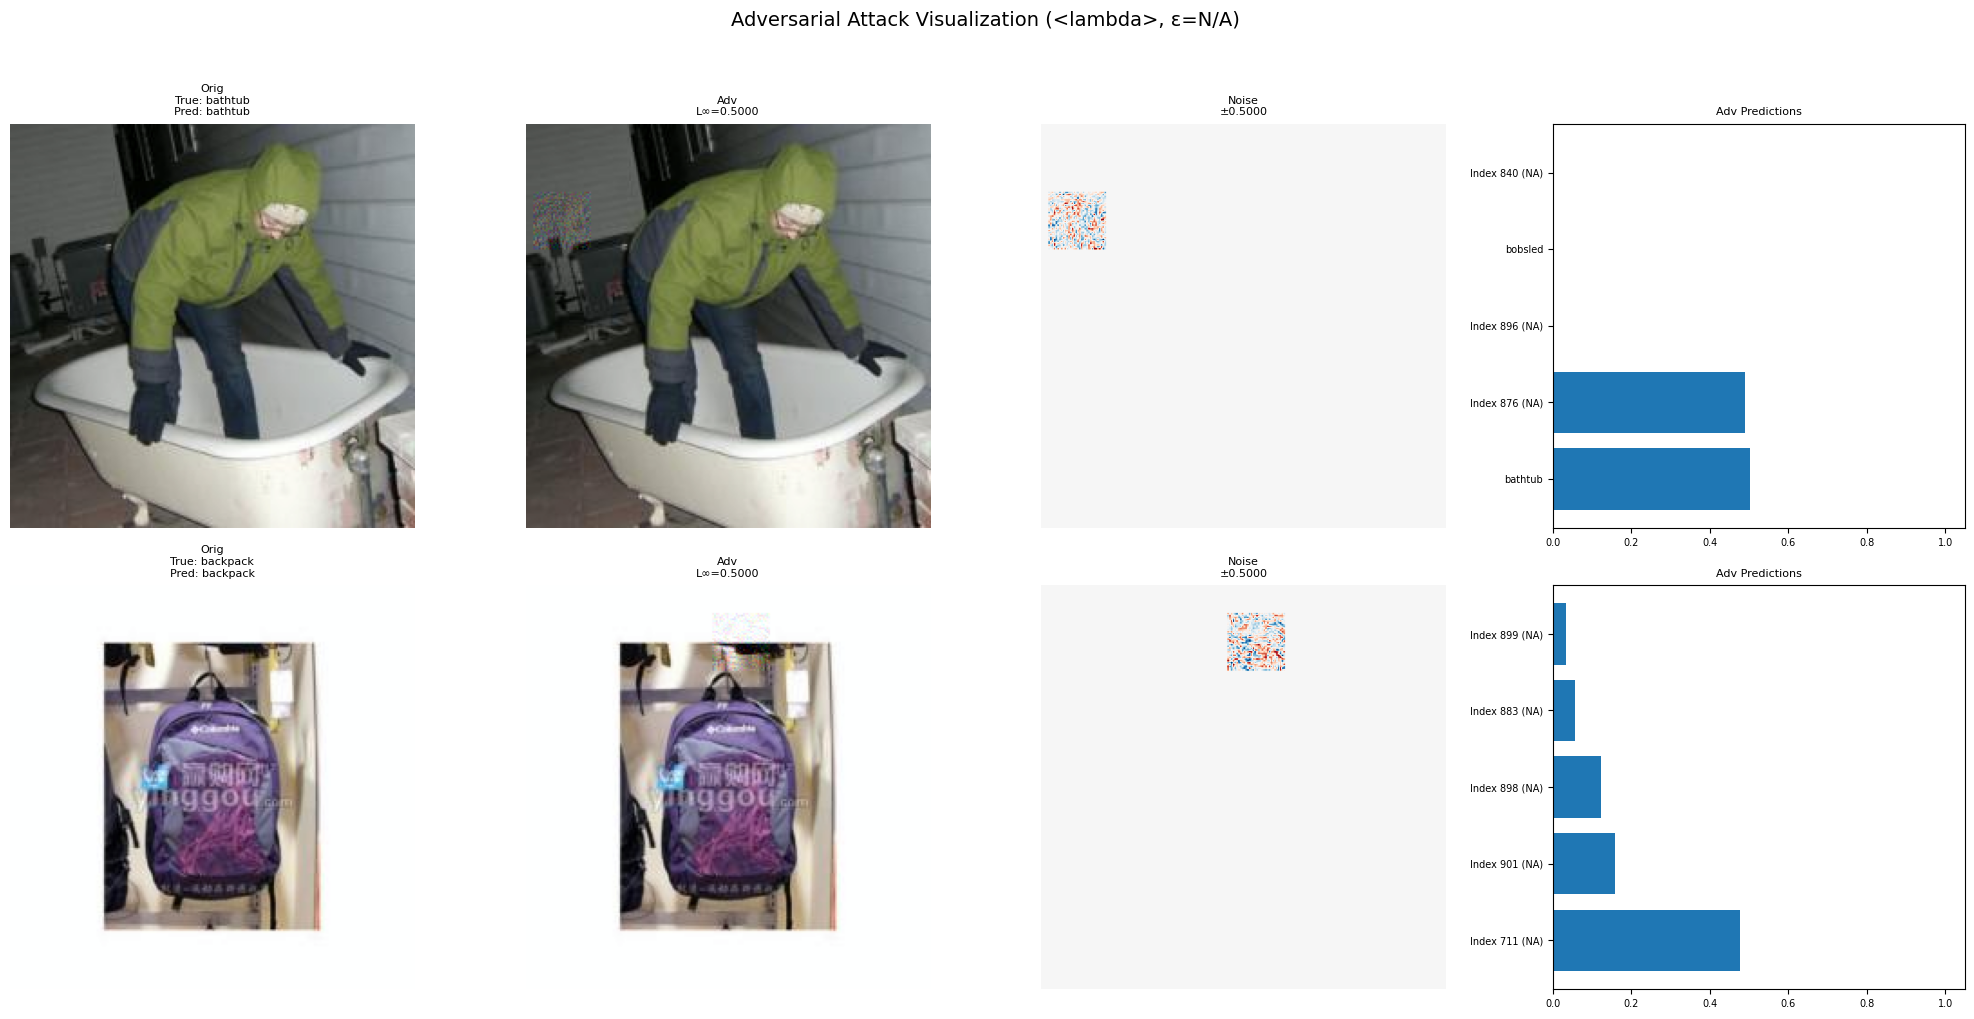

In [23]:
visualize_adversarial_examples(
    original_dataset        = original_dataset,
    model                   = model,            # predictions from ResNet-34
    device                  = device,
    imgfolder2imagenet      = imgfolder_idx_to_imagenet_idx_tensor,
    imagenet_idx_to_name    = imagenet_index_to_name,
    mean_norms              = mean_norms,
    std_norms               = std_norms,
    attack_fn               = lambda m, x, y: patch_attack_flex(m, x, y, **params),
    attack_kwargs           = {},
    tensor_to_pil_fn        = tensor_to_pil,
)

## Task 5: Transferring Attacks
Load a new model, evaluate it on all datasets (Original, FGSM, PGD, Patch), and analyze results.)
    


In [24]:
densenet = torchvision.models.densenet121(
    weights='IMAGENET1K_V1'        
).to(device)

densenet.eval()

top1_orig, top5_orig = evaluate_model(
    densenet,
    dataloader,                              # original DataLoader
    imgfolder_idx_to_imagenet_idx_tensor,    # 100-cls → 1000-cls map
    imagenet_index_to_name
)
print(f"\nDenseNet-121 – Baseline")
print(f"Top-1: {top1_orig:.2f}%   Top-5: {top5_orig:.2f}%")

adv_sets = {
    "FGSM"  : (ADVERSARIAL_SAVE_PATH_TASK1, fgsm_params["epsilon"]),
    "PGD"   : (ADVERSARIAL_SAVE_PATH_TASK2, pgd_linf_params["epsilon"]),
    "PATCH" : (ADVERSARIAL_SAVE_PATH_TASK3, params["epsilon"])
}

for name, (root, eps) in adv_sets.items():

    dl_adv, map_adv = load_adversarial_dataloader_pt(
        root=root,
        batch_size=BATCH_SIZE,
        mapping_tensor=imgfolder_idx_to_imagenet_idx_tensor,
        orig_classes=original_dataset.classes
    )
    if dl_adv is None:
        print(f"{name}: loader failed – skipped")
        continue

    top1_adv, top5_adv = evaluate_adversarial_dataset(
        model=densenet,
        dataloader=dl_adv,
        mapping_tensor=map_adv,
        imagenet_idx_to_name=imagenet_index_to_name,
        epsilon=eps,
        baseline_top1=top1_orig,
        baseline_top5=top5_orig
    )

    print(f"\nDenseNet-121 – {name} ε={eps}")
    print(f"Top-1: {top1_adv:.2f}%   Top-5: {top5_adv:.2f}%")
    print(f"ΔTop-1: {top1_orig-top1_adv:.2f}   ΔTop-5: {top5_orig-top5_adv:.2f}")

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 59.6MB/s]


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]


DenseNet-121 – Baseline
Top-1: 74.80%   Top-5: 93.60%


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]


DenseNet-121 – FGSM ε=0.02
Top-1: 63.40%   Top-5: 89.20%
ΔTop-1: 11.40   ΔTop-5: 4.40


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]


DenseNet-121 – PGD ε=0.02
Top-1: 66.40%   Top-5: 91.60%
ΔTop-1: 8.40   ΔTop-5: 2.00


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]


DenseNet-121 – PATCH ε=0.5
Top-1: 71.60%   Top-5: 92.00%
ΔTop-1: 3.20   ΔTop-5: 1.60


In [25]:
# %% [markdown]
# ### Results Summary
# (Placeholder - Present your final table of accuracies for all models and datasets.)

# %% [markdown]
# ### Discussion and Analysis
# (Placeholder - Write your discussion on the results, attack effectiveness, transferability, lessons learned, etc.)

# %% [markdown]
# ### References
# (Placeholder - List any resources or code you cited.)